In [1]:
import networkx as nx
from node2vec import Node2Vec
import gzip
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import coo_matrix
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax
from torch_geometric.data import Data
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric.utils import add_self_loops, degree
import torch
import torch.nn.functional as F
from torch.nn import Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, softmax

In [2]:
new_instances = pd.read_csv('1_new_instances.csv')
edge_index = np.loadtxt('1_edge_index.csv', delimiter=',')

new_instances, edge_index

(      routing_demand   xloc   yloc  orient  width  GRC_density  node_degree
 0               20.0  41984  44544       0   2176          3.0          681
 1               23.0  41984  47616       6   2176          2.0          681
 2               23.0  44160  44544       0   2176          3.0          681
 3               22.0  44160  47616       0   2176          2.0          681
 4               21.0  46336  47616       0   2176          1.0          681
 ...              ...    ...    ...     ...    ...          ...          ...
 3947            31.0  21888  53760       4    512          3.0          276
 3948            30.0  33664  66048       0    512          4.0          276
 3949            27.0  23296  66048       0    384          6.0          180
 3950            28.0  40576  44544       0    640          3.0          139
 3951            23.0  46848  44544       6    640          3.0           31
 
 [3952 rows x 7 columns],
 array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 3

In [3]:
# normalize xloc, yloc, congestion, width, height
# use one hot encoding for orient
onehotencoder = OneHotEncoder()
orient = onehotencoder.fit_transform(new_instances[['orient']]).toarray()

scaler = MinMaxScaler()
node_features = scaler.fit_transform(new_instances[['xloc', 'yloc', 'width', 'GRC_density', 'node_degree']])
node_features = np.concatenate((node_features, orient), axis=1)
node_features

array([[0.49617152, 0.5       , 0.51851852, ..., 0.        , 0.        ,
        0.        ],
       [0.49617152, 0.53571429, 0.51851852, ..., 0.        , 0.        ,
        1.        ],
       [0.52220521, 0.5       , 0.51851852, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.27258806, 0.75      , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.47932619, 0.5       , 0.07407407, ..., 0.        , 0.        ,
        0.        ],
       [0.55436447, 0.5       , 0.07407407, ..., 0.        , 0.        ,
        1.        ]])

In [5]:
# scaler_demand = MinMaxScaler()
# demand = scaler_demand.fit_transform(new_instances[['routing_demand']])
demand = new_instances[['routing_demand']].values
demand

array([[20.],
       [23.],
       [23.],
       ...,
       [27.],
       [28.],
       [23.]])

In [6]:
edge_index = torch.tensor(edge_index, dtype=torch.long)
x = torch.tensor(node_features, dtype=torch.float)
y = torch.tensor(demand, dtype=torch.float)

data = Data(x=x, edge_index=edge_index, y=y)

In [7]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.6):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Add self-loops to the edge_index
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        x = F.relu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=self.dropout, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)

        return x

In [8]:
class GATConv(MessagePassing):
    def __init__(self, in_channels, out_channels, heads=1, concat=True, dropout=0.6):
        super(GATConv, self).__init__(node_dim=0, aggr='add')  # "Add" aggregation.
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.concat = concat
        self.dropout = dropout

        # Linear transformation matrices
        self.weight = Parameter(torch.Tensor(in_channels, heads * out_channels))
        # Attention coefficients
        self.attention = Parameter(torch.Tensor(1, heads, 2 * out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.xavier_uniform_(self.attention)

    def forward(self, x, edge_index):
        x = torch.mm(x, self.weight).view(-1, self.heads, self.out_channels)
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        return self.propagate(edge_index, x=x, size=None)

    def message(self, edge_index_i, x_i, x_j, size_i):
        # Compute attention coefficients
        x = torch.cat([x_i, x_j], dim=-1)
        alpha = (x * self.attention).sum(dim=-1)
        alpha = F.leaky_relu(alpha, 0.2)
        alpha = softmax(alpha, edge_index_i, num_nodes=size_i)

        # Sample dropout for attention coefficients
        alpha = F.dropout(alpha, p=self.dropout, training=self.training)

        return x_j * alpha.view(-1, self.heads, 1)

    def update(self, aggr_out):
        if self.concat:
            aggr_out = aggr_out.view(-1, self.heads * self.out_channels)
        else:
            aggr_out = aggr_out.mean(dim=1)
        return aggr_out

class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=1, dropout=0.6):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        self.conv2 = GATConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout)
        self.conv3 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        # x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv2(x, edge_index))
        # x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [27]:
# set random seed
torch.manual_seed(0)

num_nodes =  node_features.shape[0]
train_size = int(num_nodes * 0.8)  # Let's say 80% for training
val_size = int(num_nodes * 0.1)  # 10% for validation

# Create a random permutation of node indices
perm = torch.randperm(num_nodes)

# Use the first 80% of randomly permuted indices for training
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[perm[:train_size]] = True

# Next 10% for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[train_size:train_size+val_size]] = True

# Last 10% for testing
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[perm[train_size+val_size:]] = True

# Assign masks to your data object
data.train_mask = train_mask
data.val_mask = val_mask
data.test_mask = test_mask

In [30]:
sum(train_mask)

tensor(3161)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GCN_model = GCN(in_channels=9, hidden_channels=9, out_channels=1, dropout=0).to(device)
GCN_optimizer = torch.optim.Adam(GCN_model.parameters(), lr=0.005, weight_decay=5e-4)

GCN_loss_values = []
GCN_valid_loss_values = []

GCN_model.train()
for epoch in range(300):
    GCN_optimizer.zero_grad()
    GCN_out = GCN_model(data)
    GCN_loss = F.mse_loss(GCN_out[data.train_mask], data.y[data.train_mask])
    GCN_valid_loss = F.mse_loss(GCN_out[data.val_mask], data.y[data.val_mask])
    GCN_loss.backward()
    GCN_optimizer.step()
    GCN_loss_values.append(GCN_loss.item())
    GCN_valid_loss_values.append(GCN_valid_loss.item())
    print(f'Epoch {epoch+1}, Loss: {GCN_loss.item()}')

Epoch 1, Loss: 675.428955078125
Epoch 2, Loss: 674.2100830078125
Epoch 3, Loss: 672.8938598632812
Epoch 4, Loss: 671.4695434570312
Epoch 5, Loss: 669.9176635742188
Epoch 6, Loss: 668.2329711914062
Epoch 7, Loss: 666.412841796875
Epoch 8, Loss: 664.4585571289062
Epoch 9, Loss: 662.3719482421875
Epoch 10, Loss: 660.1517944335938
Epoch 11, Loss: 657.79296875
Epoch 12, Loss: 655.2821655273438
Epoch 13, Loss: 652.5968017578125
Epoch 14, Loss: 649.7056274414062
Epoch 15, Loss: 646.6193237304688
Epoch 16, Loss: 643.3370971679688
Epoch 17, Loss: 639.8502807617188
Epoch 18, Loss: 636.1488647460938
Epoch 19, Loss: 632.2242431640625
Epoch 20, Loss: 628.06640625
Epoch 21, Loss: 623.6660766601562
Epoch 22, Loss: 619.0138549804688
Epoch 23, Loss: 614.1007690429688
Epoch 24, Loss: 608.9172973632812
Epoch 25, Loss: 603.45458984375
Epoch 26, Loss: 597.7036743164062
Epoch 27, Loss: 591.6559448242188
Epoch 28, Loss: 585.3035278320312
Epoch 29, Loss: 578.6383056640625
Epoch 30, Loss: 571.6531982421875
Epo

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GAT_model = GAT(in_channels=9, hidden_channels=9, out_channels=1, heads=9, dropout=0).to(device)
GAT_optimizer = torch.optim.Adam(GAT_model.parameters(), lr=0.005, weight_decay=5e-4)

GAT_loss_values = []
GAT_valid_loss_values = []

GAT_model.train()
for epoch in range(300):
    GAT_optimizer.zero_grad()
    GAT_out = GAT_model(data)
    GAT_loss = F.mse_loss(GAT_out[data.train_mask], data.y[data.train_mask])
    GAT_valid_loss = F.mse_loss(GAT_out[data.val_mask], data.y[data.val_mask])
    GAT_loss.backward()
    GAT_optimizer.step()
    GAT_loss_values.append(GAT_loss.item())
    GAT_valid_loss_values.append(GAT_valid_loss.item())
    print(f'Epoch {epoch+1}, Loss: {GAT_loss.item()}')

Epoch 1, Loss: 679.1082153320312
Epoch 2, Loss: 636.3193359375
Epoch 3, Loss: 593.8746337890625
Epoch 4, Loss: 550.3555297851562
Epoch 5, Loss: 505.0856018066406
Epoch 6, Loss: 457.7872009277344
Epoch 7, Loss: 408.56494140625
Epoch 8, Loss: 357.79888916015625
Epoch 9, Loss: 306.1635437011719
Epoch 10, Loss: 254.60328674316406
Epoch 11, Loss: 204.3354949951172
Epoch 12, Loss: 156.82916259765625
Epoch 13, Loss: 113.83940887451172
Epoch 14, Loss: 77.2850570678711
Epoch 15, Loss: 49.24445724487305
Epoch 16, Loss: 31.60959815979004
Epoch 17, Loss: 25.586519241333008
Epoch 18, Loss: 30.820602416992188
Epoch 19, Loss: 44.39875793457031
Epoch 20, Loss: 60.838165283203125
Epoch 21, Loss: 74.12273406982422
Epoch 22, Loss: 80.3886947631836
Epoch 23, Loss: 78.91972351074219
Epoch 24, Loss: 71.35136413574219
Epoch 25, Loss: 60.34222412109375
Epoch 26, Loss: 48.551185607910156
Epoch 27, Loss: 38.04049301147461
Epoch 28, Loss: 30.059799194335938
Epoch 29, Loss: 25.073062896728516
Epoch 30, Loss: 22.9

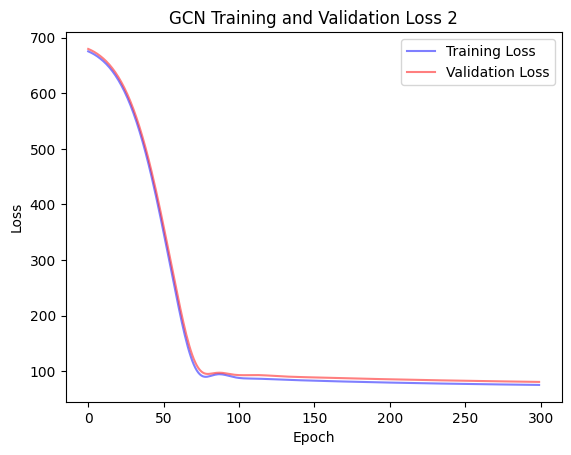

In [35]:
for i in range(0, 3):
    plt.clf()
    plt.plot(GCN_loss_values, label='Training Loss', color='blue', alpha=0.5)
    plt.plot(GCN_valid_loss_values, label='Validation Loss', color='red', alpha=0.5)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f"GCN Training and Validation Loss {i}")
    plt.legend()
    plt.savefig(f"GCN_TV_loss/{i}.pdf")
    # plt.show()

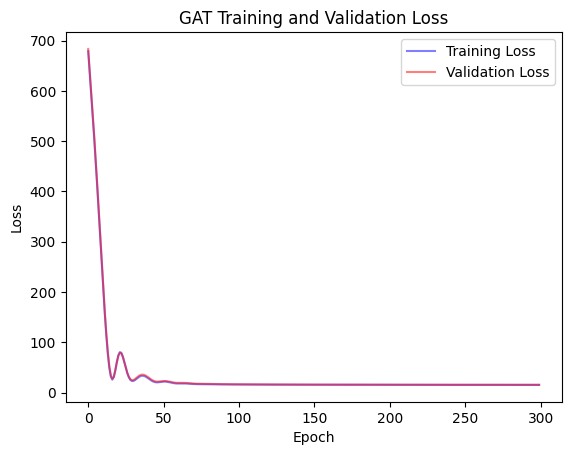

In [25]:
plt.plot(GAT_loss_values, label='Training Loss', color='blue', alpha=0.5)
plt.plot(GAT_valid_loss_values, label='Validation Loss', color='red', alpha=0.5)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GAT Training and Validation Loss')
plt.legend()
plt.show()

In [26]:
# Evaluate the model
GCN_model.eval()
GCN_out =GCN_model(data)
GCN_loss = F.mse_loss(GCN_out[data.test_mask], data.y[data.test_mask])
print(f'GCN_Test Loss: {GCN_loss.item()}')

GCN_Test Loss: 82.5930404663086


In [124]:
GAT_model.eval()
GAT_out =GAT_model(data)
GAT_loss = F.mse_loss(GAT_out[data.test_mask], data.y[data.test_mask])
print(f'GAT_Test Loss: {GAT_loss.item()}')

GAT_Test Loss: 12.759267807006836


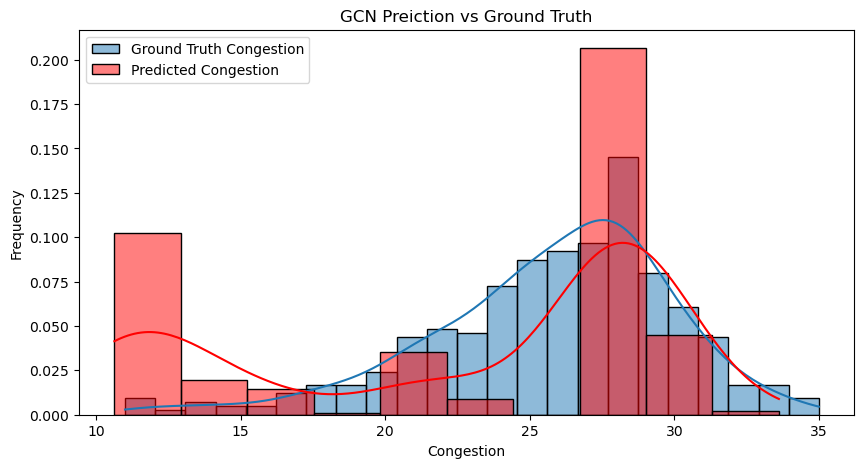

In [125]:
# plot the distribution of original congestion and predicted congestion
plt.figure(figsize=(10, 5))
sns.histplot(data.y[data.test_mask].cpu().detach().numpy(), kde=True, label='Ground Truth Congestion', stat="density", color='blue')
sns.histplot(GCN_out[data.test_mask].cpu().detach().numpy().flatten(), kde=True, label='Predicted Congestion', stat="density", color='red')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('GCN Preiction vs Ground Truth')
plt.legend()
plt.show()

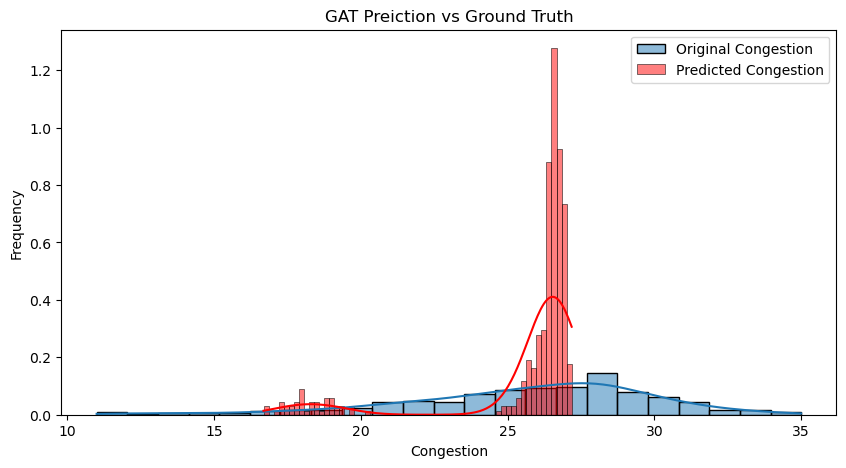

In [126]:
plt.figure(figsize=(10, 5))
sns.histplot(data.y[data.test_mask].cpu().detach().numpy(), kde=True, label='Original Congestion', stat="density", color='blue')
sns.histplot(GAT_out[data.test_mask].cpu().detach().numpy().flatten(), kde=True, label='Predicted Congestion', stat="density", color='red')
plt.xlabel('Congestion')
plt.ylabel('Frequency')
plt.title('GAT Preiction vs Ground Truth')
plt.legend()
plt.show()

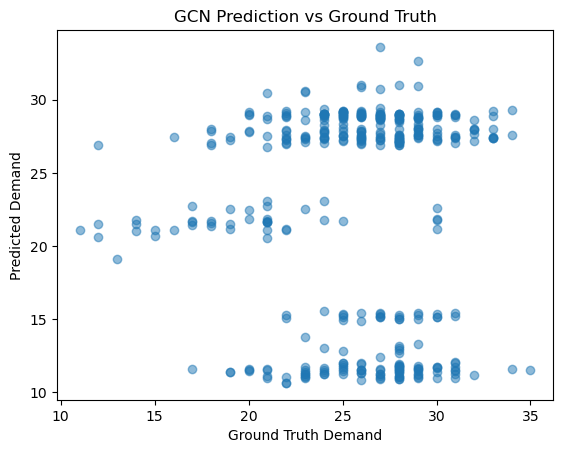

In [127]:
plt.scatter(data.y[data.test_mask].cpu().detach().numpy(), GCN_out[data.test_mask].cpu().detach().numpy(), alpha=0.5)
plt.xlabel('Ground Truth Demand')
plt.ylabel('Predicted Demand')
plt.title('GCN Prediction vs Ground Truth')
plt.show()

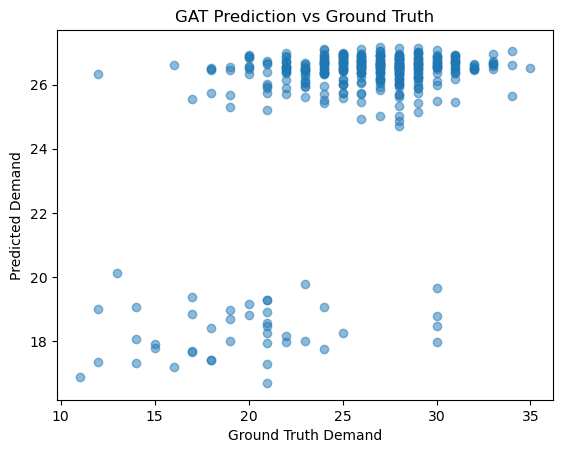

In [128]:
plt.scatter(data.y[data.test_mask].cpu().detach().numpy(), GAT_out[data.test_mask].cpu().detach().numpy(), alpha=0.5)
plt.xlabel('Ground Truth Demand')
plt.ylabel('Predicted Demand')
plt.title('GAT Prediction vs Ground Truth')

plt.show()

In [129]:
# calculate Pearson correlation coefficient, kendall correlation coefficient, and test RMSE
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, kendalltau

GCN_rmse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), GCN_out[data.test_mask].cpu().detach().numpy(), squared=False)
GAT_rmse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), GAT_out[data.test_mask].cpu().detach().numpy(), squared=False)

GCN_pearson = pearsonr(data.y[data.test_mask].cpu().detach().numpy().flatten(), GCN_out[data.test_mask].cpu().detach().numpy().flatten())
GAT_pearson = pearsonr(data.y[data.test_mask].cpu().detach().numpy().flatten(), GAT_out[data.test_mask].cpu().detach().numpy().flatten())

GCN_kendall = kendalltau(data.y[data.test_mask].cpu().detach().numpy().flatten(), GCN_out[data.test_mask].cpu().detach().numpy().flatten())
GAT_kendall = kendalltau(data.y[data.test_mask].cpu().detach().numpy().flatten(), GAT_out[data.test_mask].cpu().detach().numpy().flatten())

print(f'GCN RMSE: {GCN_rmse}')
print(f'GAT RMSE: {GAT_rmse}')
print(f'GCN Pearson Correlation: {GCN_pearson}')
print(f'GAT Pearson Correlation: {GAT_pearson}')
print(f'GCN Kendall Correlation: {GCN_kendall}')
print(f'GAT Kendall Correlation: {GAT_kendall}')



GCN RMSE: 8.9054594039917
GAT RMSE: 3.572011709213257
GCN Pearson Correlation: PearsonRResult(statistic=0.01808298444563685, pvalue=0.7197906128933256)
GAT Pearson Correlation: PearsonRResult(statistic=0.5153455949662833, pvalue=3.0183908041037366e-28)
GCN Kendall Correlation: KendalltauResult(correlation=0.03446881562794271, pvalue=0.32288100900663663)
GAT Kendall Correlation: KendalltauResult(correlation=0.20030758661132125, pvalue=9.205218802335487e-09)


In [130]:
# calculate the mse of a naive model that predicts the average of the training set
average_demand = data.y[data.train_mask].mean()
naive_mse = mean_squared_error(data.y[data.test_mask].cpu().detach().numpy(), np.full(data.y[data.test_mask].shape, average_demand), squared=False)
naive_mse

4.1372385

In [132]:
# store the results in a dataframe
results = pd.DataFrame({'Model': ['GCN', 'GAT', 'Naive'], 'RMSE': [GCN_rmse, GAT_rmse, naive_mse], 'Pearson Correlation': [GCN_pearson, GAT_pearson, (0, 0)], 'Kendall Correlation': [GCN_kendall, GAT_kendall, (0, 0)]})
results

,Model,RMSE,Pearson Correlation,Kendall Correlation
0,GCN,8.905459,"(0.01808298444563685, 0.7197906128933256)","(0.03446881562794271, 0.32288100900663663)"
1,GAT,3.572012,"(0.5153455949662833, 3.0183908041037366e-28)","(0.20030758661132125, 9.205218802335487e-09)"
2,Naive,4.137239,"(0, 0)","(0, 0)"


In [ ]:
results.to_csv('1_results.csv', index=False)